# Cross-Entropy Method

In this notebook we will train OpenAI Gym's MountainCarContinous Environment with Cross-Entropy Method

# 1. Importing Necessarry Packages

In [1]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# 2. Instantiate the Environment

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation_space :', env.observation_space)
print('action_space :', env.action_space)
print(' - low :', env.action_space.low)
print(' - high : ', env.action_space.high)

observation_space : Box(2,)
action_space : Box(1,)
 - low : [-1.]
 - high :  [ 1.]


# 3. Instantiate the Agent

In [3]:
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden_layer, action_sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def forward(self , x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x
    
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # Seperate the weights for each layer
        fc1_end = (s_size * h_size) + h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[(s_size*h_size):fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end + (h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[(fc1_end + (h_size*a_size)):])
        # Set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
        
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x.cpu().data
    
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)
agent 

Agent(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

In [4]:
state_size = env.observation_space.shape[0]
hidden_size = 16
action_size = env.action_space.shape[0]
print(state_size, hidden_size, action_size)

fc1_end = (state_size*hidden_size) + hidden_size
print("fc1_end :", fc1_end)

# Weights dimensions 
total_weights = (state_size + 1)*hidden_size + (hidden_size + 1)*action_size
print("total_weights : ", total_weights)




2 16 1
fc1_end : 48
total_weights :  65


In [5]:
print(agent.fc1.weight.shape)
print(agent.fc1.bias.shape)
print(agent.fc2.weight.shape)
print(agent.fc2.bias.shape)

torch.Size([16, 2])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])


In [6]:
print(agent.get_weights_dim())

65


In [7]:
weights = np.random.randn(agent.get_weights_dim())
print(weights)

[  2.70684984e+00   6.28132709e-01   9.07969446e-01   5.03825754e-01
   6.51117948e-01  -3.19318045e-01  -8.48076983e-01   6.05965349e-01
  -2.01816824e+00   7.40122057e-01   5.28813494e-01  -5.89000533e-01
   1.88695309e-01  -7.58872056e-01  -9.33237216e-01   9.55056509e-01
   1.90794322e-01   1.97875732e+00   2.60596728e+00   6.83508886e-01
   3.02665449e-01   1.69372293e+00  -1.70608593e+00  -1.15911942e+00
  -1.34840721e-01   3.90527843e-01   1.66904636e-01   1.84501859e-01
   8.07705914e-01   7.29596753e-02   6.38787013e-01   3.29646299e-01
  -4.97104023e-01  -7.54069701e-01  -9.43406403e-01   4.84751647e-01
  -1.16773316e-01   1.90175480e+00   2.38126959e-01   1.99665229e+00
  -9.93263500e-01   1.96799505e-01  -1.13664459e+00   3.66479606e-04
   1.02598415e+00  -1.56597904e-01  -3.15791439e-02   6.49825833e-01
   2.15484644e+00  -6.10258856e-01  -7.55325340e-01  -3.46418504e-01
   1.47026771e-01  -4.79448039e-01   5.58769406e-01   1.02481028e+00
  -9.25874259e-01   1.86286414e+00

In [8]:
fc1_end = (state_size*hidden_size) + hidden_size
print(fc1_end)
# Seperating weights for each layer
fc1_W = torch.from_numpy(weights[:state_size*hidden_size].reshape(state_size, hidden_size))
print(fc1_W, fc1_W.shape)
fc1_b = torch.from_numpy(weights[state_size*hidden_size:fc1_end])
print(fc1_b, fc1_b.shape)
fc2_W = torch.from_numpy(weights[fc1_end:fc1_end + hidden_size*action_size].reshape(hidden_size, action_size))
print(fc2_W, fc2_W.shape)
fc2_b = torch.from_numpy(weights[(fc1_end + hidden_size*action_size):])
print(fc2_b, fc2_b.shape)


48
tensor([[ 2.7068,  0.6281,  0.9080,  0.5038,  0.6511, -0.3193, -0.8481,  0.6060,
         -2.0182,  0.7401,  0.5288, -0.5890,  0.1887, -0.7589, -0.9332,  0.9551],
        [ 0.1908,  1.9788,  2.6060,  0.6835,  0.3027,  1.6937, -1.7061, -1.1591,
         -0.1348,  0.3905,  0.1669,  0.1845,  0.8077,  0.0730,  0.6388,  0.3296]],
       dtype=torch.float64) torch.Size([2, 16])
tensor([-0.4971, -0.7541, -0.9434,  0.4848, -0.1168,  1.9018,  0.2381,  1.9967,
        -0.9933,  0.1968, -1.1366,  0.0004,  1.0260, -0.1566, -0.0316,  0.6498],
       dtype=torch.float64) torch.Size([16])
tensor([[ 2.1548],
        [-0.6103],
        [-0.7553],
        [-0.3464],
        [ 0.1470],
        [-0.4794],
        [ 0.5588],
        [ 1.0248],
        [-0.9259],
        [ 1.8629],
        [-1.1338],
        [ 0.6105],
        [ 0.3860],
        [ 2.0840],
        [-0.3765],
        [ 0.2303]], dtype=torch.float64) torch.Size([16, 1])
tensor([0.6812], dtype=torch.float64) torch.Size([1])


In [9]:
a = np.arange(48)
print(a[:32])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


In [10]:
print(env.observation_space.shape[0])

2


In [11]:
print(env.action_space.shape[0])

1


# 3. Train the agent with the Cross-Entropy Method


Episode 10	Average Score: -13.57
Episode 20	Average Score: -7.55
Episode 30	Average Score: -5.31
Episode 40	Average Score: -4.04
Episode 50	Average Score: -3.32
Episode 60	Average Score: -2.89
Episode 70	Average Score: 4.47
Episode 80	Average Score: 15.59
Episode 90	Average Score: 24.40
Episode 100	Average Score: 31.47
Episode 110	Average Score: 42.35
Episode 120	Average Score: 52.01
Episode 130	Average Score: 61.57
Episode 140	Average Score: 70.98
Episode 150	Average Score: 80.58
Episode 160	Average Score: 90.20

Environment solved in 60 iterations!	Average Score: 90.20


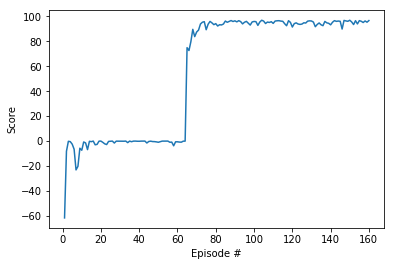

In [12]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()